In [1]:
from models import train_predict,CondensedGoogLeNet
from models.train_predict import get_confusion_matrix
from data.data_processing import generate_dummy_data,DataHandler,get_training_data_from_path
from config.hyperparams import GoogleNet_hyperparams
import tensorflow as tf
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
folder_for_samples = 'data/cnn_samples/regular'

# Data Processing

## Get stock data in Handler object

In [3]:
handler = DataHandler(encoding_method='GADF', window_len=64, image_size=16, retrain_freq=5,
                 start_date = 20100102, end_date= 20200102, frac_of_stocks=0.4,
                stock_data_dir_path= 'data/stock_data',
                 dir_for_samples=folder_for_samples, nb_of_stocks_by_file=50
                 )

In [4]:
handler.get_df_data()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

AttributeError: Unknown property figsize

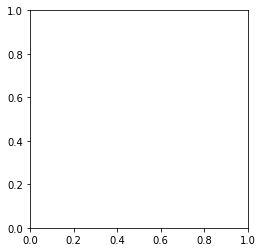

In [10]:
handler.show_image(handler.df_data)

## Builds images and targets and creates pickles
+ Be careful for the folder name (specified in handler object), this function will delete all files in this folder before dumping pickles

In [5]:
handler.build_and_dump_images_and_targets()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

# Training

## Retrieve data from the specified folder

In [8]:
%%time

X_train, X_val, X_test, Y_train, Y_val, Y_test = get_training_data_from_path(samples_path=folder_for_samples,
                                targets_type='VWAP_targets',
                                train_val_size=2 / 3.,
                                train_size=0.75,
                                logger_env='Training')


Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Wall time: 544 ms


## Build the neural network object

In [9]:
shape_x,shape_y = list(X_train.shape),list(Y_train.shape)
shape_x[0],shape_y[0] = None,None

GoogleNet_hyperparams.update({'learning_rate':0.001})

network = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)

## Train the network 

In [12]:
n_test = 13000

X_train1, X_val1, Y_train1, Y_val1 =  X_train[:n_test], X_val[:n_test], Y_train[:n_test], Y_val[:n_test]


GN_pred, GN_training_loss, GN_val_loss = train_predict(X=X_train1, Y=Y_train1, batch_size=15, valX=X_val1, valY=Y_val1,
                                                       model_ckpt_path='model_checkpoints/ckpt1.meta', is_bayesian=True,
                                                       epochs=2, net=network, dropout=0.15,save_step =5,cost_sensitive_loss=True)

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

In [11]:
get_confusion_matrix(Y_val,GN_pred)

array([[1382, 1614,  555],
       [ 968, 1977,  664],
       [ 682, 1326,  890]], dtype=int64)